In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import cartopy.feature as cfea

In [2]:
def load(name, SUF='.hlf', day=356, second=86400, coef=1e12):
    if SUF == '.hlf':
        shape = (360, 720)
        areapath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_ara_/lndara.WFDEI.hlf'
        maskpath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_msk_/lndmsk.WFDEI.hlf'
    elif SUF == '.gl5':
        shape = (2160, 4320)
        areapath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_ara_/lndara.CAMA.gl5'
        maskpath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_msk_/lndmsk.CAMA.gl5'
    dtype = 'float32' # 4バイト
    h08dir = '/home/kajiyama/H08/H08_20230612/'
    file = h08dir + name
    
    # data
    data = np.fromfile(file, dtype=dtype)
    lonlat = data.reshape(shape)
    
    # mask out
    mask = np.fromfile(maskpath, dtype=dtype)
    mask = mask.reshape(shape)
    lonlat = np.ma.masked_where(mask==0, lonlat)
    lonlat = np.ma.masked_where(lonlat>1e19, lonlat)
    
    return lonlat

In [3]:
def load_yearly(name, SUF='.hlf', day=356, second=86400, coef=1e12):
    if SUF == '.hlf':
        shape = (360, 720)
        maskpath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_msk_/lndmsk.WFDEI.hlf'
    elif SUF == '.gl5':
        shape = (2160, 4320)
        maskpath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_msk_/lndmsk.CAMA.gl5'
    dtype = 'float32' # 4バイト
    lnddir = '/home/kajiyama/H08/H08_20230612/'
    file = lnddir + name
    
    # data
    data = np.fromfile(file, dtype=dtype)
    lonlat = data.reshape(shape)
    
    # mask out
    mask = np.fromfile(maskpath, dtype=dtype)
    mask = mask.reshape(shape)
    lonlat = np.ma.masked_where(mask==0, lonlat)
    lonlat = np.ma.masked_where(lonlat>1e19, lonlat)
    
    # conversion second to year
    adm = lonlat*day*second
    
    # conversion from kg to mm3
    # 1000kg = 1m3 = 1e9mm3
    # km3 = kg/1e12
    adm = adm/coef
    
    # sum up
    total = np.sum(adm)
    print(f"total {total} km3/year")
    
    return adm

In [4]:
def load_times_area(name, SUF='.hlf', day=356, second=86400, coef=1e12):
    if SUF == '.hlf':
        shape = (360, 720)
        areapath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_ara_/lndara.WFDEI.hlf'
        maskpath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_msk_/lndmsk.WFDEI.hlf'
    elif SUF == '.gl5':
        shape = (2160, 4320)
        areapath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_ara_/lndara.CAMA.gl5'
        maskpath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_msk_/lndmsk.CAMA.gl5'
    dtype = 'float32' # 4バイト
    lnddir = '/home/kajiyama/H08/H08_20230612/'
    file = lnddir + name
    
    # area
    area = np.fromfile(areapath, dtype=dtype)
    area = area.reshape(shape)
    
    # data
    data = np.fromfile(file, dtype=dtype)
    lonlat = data.reshape(shape)
    
    # mask out
    mask = np.fromfile(maskpath, dtype=dtype)
    mask = mask.reshape(shape)
    lonlat = np.ma.masked_where(mask==0, lonlat)
    lonlat = np.ma.masked_where(lonlat>1e19, lonlat)
    
    # multiply area
    adm = lonlat*area
    
    # conversion from mm/s to mm/year
    adm = adm*day*second
    
    # conversion from kg to mm3
    # 1000kg = 1m3 = 1e9mm3
    # km3 = kg/1e12
    adm = adm/coef
    
    # sum up
    total = np.sum(adm)
    print(f"total {total} km3/year")
    
    return adm

In [5]:
def crop(data, lat_start, lat_end, lon_start, lon_end):
    data_flipped = np.flipud(data)
    data_cropped = data_flipped[lat_start:lat_end, lon_start:lon_end]
    cropped_flipped = np.flipud(data_cropped)
    return cropped_flipped

In [6]:
def get_coordinate(city_index):
    # open city information text
    city_path = '/home/kajiyama/H08/H08_20230612/map/dat/cty_lst_/cityrange_list_temp.txt'
    with open(city_path, "r") as file:
        all_lines = file.readlines()
    # get city
    line = all_lines[city_index - 1]
    line = line.strip()
    parts = line.split()
    
    city_num = parts[0].zfill(3)
    city = parts[5].replace("\"", "").replace("?", "").replace("/", "")
    
    lonmin = float(parts[6])
    lonmax = float(parts[7])
    latmin = float(parts[8])
    latmax = float(parts[9])

    # Dimension of the data
    a = 2160
    b = 4320

    ### Define the latitudes and longitudes
    # West from UK is negative 0 <= lon <= -180
    # East from UK is positive 0 <= lon <= 180
    # small value to larger value (34-36, 138-140)
    lat = np.linspace(-90, 90, a+1)
    lon = np.linspace(-180, 180, b+1)

    # calculate the indices correspondignt to the desired lat and lon
    lat_start, lat_end = np.searchsorted(lat, [latmin, latmax])
    lon_start, lon_end = np.searchsorted(lon, [lonmin, lonmax])

    ### adjust to 0.25 grid
    # lat
    if lat_start%3 == 0:
        lat_start = lat_start
    elif lat_start%3 == 1:
        lat_start -= 1
    elif lat_start%3 == 2:
        lat_start += 1

    # lon
    if lon_start%3 == 0:
        lon_start = lon_start
    elif lon_start%3 == 1:
        lon_start -= 1
    elif lon_start%3 == 2:
        lon_start += 1

    # 24 grid x 24 grid
    lat_end = lat_start + 24
    lon_end = lon_start + 24

    # convert real lonlat to h08 lonlat
    latmin_gl5 = lat[lat_start]
    latmax_gl5 = lat[lat_end]
    lonmin_gl5 = lon[lon_start]
    lonmax_gl5 = lon[lon_end]
    
    return lat_start, lat_end, lon_start, lon_end, latmin_gl5, latmax_gl5, lonmin_gl5, lonmax_gl5

# main

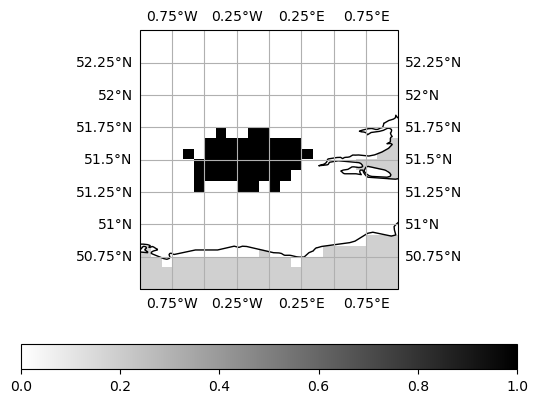

In [19]:
# 都市マスク
# load data
city_index = 29
lat_start, lat_end, lon_start, lon_end, latmin_gl5, latmax_gl5, lonmin_gl5, lonmax_gl5 = get_coordinate(city_index)
city = load(f'map/dat/cty_msk_/city_{city_index:08d}.gl5', SUF='.gl5')

# crop
city_cropped = crop(city, lat_start, lat_end, lon_start, lon_end)

# extent
projection = ccrs.PlateCarree()
img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfea.OCEAN, color='#d0d0d0')
im = ax.imshow(city_cropped,
               origin='upper',
               extent=img_extent,
               transform=projection,
               cmap='gray_r')
fig.colorbar(im, ax=ax, orientation='horizontal')

In [8]:
# 都市のマスク内の水需要の内訳
# AGR灌漑用水　InD工業用水 Dom生活用水

# London

total 548.2949222150963 km3/year
masked_total 0.0 km3/year


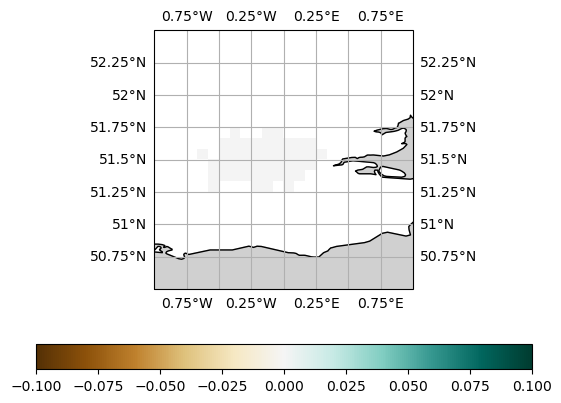

In [20]:
# suplyの単位はkg/s

# load demagr tokyo
supagr = load_yearly('lnd/out/SupAgr__/W5E5LECD20190000.gl5', SUF='.gl5')
supagr_cropped = crop(supagr, lat_start, lat_end, lon_start, lon_end)

# city mask
masked_supagr = np.where(city_cropped == 1, supagr_cropped, np.nan)

# extent
projection = ccrs.PlateCarree()
img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfea.OCEAN, color='#d0d0d0')
im = ax.imshow(masked_supagr,
               origin='upper',
               extent=img_extent,
               transform=projection,
               cmap='BrBG'
               #cmap='GnBu',
               #norm = LogNorm(vmin=1e-10, vmax=1e2),
              )
fig.colorbar(im, ax=ax, orientation='horizontal')

print(f"masked_total {np.nansum(masked_supagr)} km3/year")

total 58.833098833797926 km3/year
masked_total 0.06492258255234375 km3/year


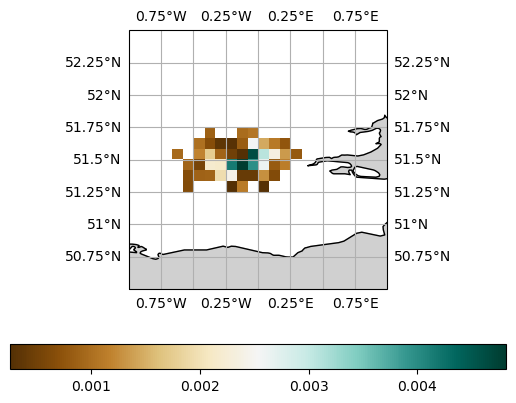

In [21]:
# load demagr tokyo
supind = load_yearly('lnd/out/SupInd__/W5E5LECD20190000.gl5', SUF='.gl5')
supind_cropped = crop(supind, lat_start, lat_end, lon_start, lon_end)

# city mask
masked_supind = np.where(city_cropped == 1, supind_cropped, np.nan)

# extent
projection = ccrs.PlateCarree()
img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfea.OCEAN, color='#d0d0d0')
im = ax.imshow(masked_supind,
               origin='upper',
               extent=img_extent,
               transform=projection,
               cmap='BrBG'
               #cmap='GnBu',
               #norm = LogNorm(vmin=1e-10, vmax=1e2),
              )
fig.colorbar(im, ax=ax, orientation='horizontal')

print(f"masked_total {np.nansum(masked_supind)} km3/year")

total 52.552453683538296 km3/year
masked_total 0.11979571418437499 km3/year


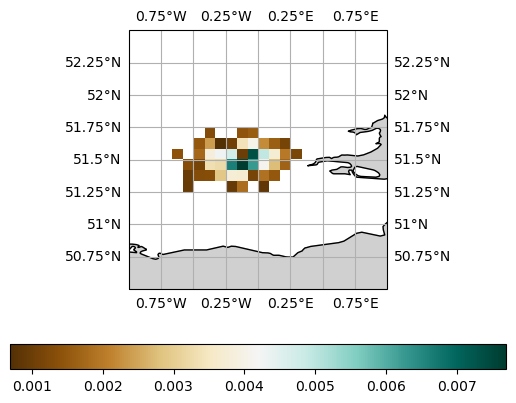

In [22]:
# load demagr tokyo
supdom = load_yearly('lnd/out/SupDom__/W5E5LECD20190000.gl5', SUF='.gl5')
supdom_cropped = crop(supdom, lat_start, lat_end, lon_start, lon_end)

# city mask
masked_supdom = np.where(city_cropped == 1, supdom_cropped, np.nan)

# extent
projection = ccrs.PlateCarree()
img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfea.OCEAN, color='#d0d0d0')
im = ax.imshow(masked_supdom,
               origin='upper',
               extent=img_extent,
               transform=projection,
               cmap='BrBG'
               #cmap='GnBu',
               #norm = LogNorm(vmin=1e-10, vmax=1e2),
              )
fig.colorbar(im, ax=ax, orientation='horizontal')

print(f"masked_total {np.nansum(masked_supdom)} km3/year")

In [23]:
# load demagr tokyo
river = load_yearly('lnd/out/SupDomR_/W5E5LECD20190000.gl5', SUF='.gl5')
river_cropped = crop(river, lat_start, lat_end, lon_start, lon_end)
masked_river = np.where(city_cropped == 1, river_cropped, np.nan)
print(f"masked_total {np.nansum(masked_river)} km3/year")

# load demagr tokyo
river = load_yearly('lnd/out/SupDomC_/W5E5LECD20190000.gl5', SUF='.gl5')
river_cropped = crop(river, lat_start, lat_end, lon_start, lon_end)
masked_river = np.where(city_cropped == 1, river_cropped, np.nan)
print(f"masked_total {np.nansum(masked_river)} km3/year")

# load demagr tokyo
river = load_yearly('lnd/out/SupDomGR/W5E5LECD20190000.gl5', SUF='.gl5')
river_cropped = crop(river, lat_start, lat_end, lon_start, lon_end)
masked_river = np.where(city_cropped == 1, river_cropped, np.nan)
print(f"masked_total {np.nansum(masked_river)} km3/year")

# load demagr tokyo
river = load_yearly('lnd/out/SupDomM_/W5E5LECD20190000.gl5', SUF='.gl5')
river_cropped = crop(river, lat_start, lat_end, lon_start, lon_end)
masked_river = np.where(city_cropped == 1, river_cropped, np.nan)
print(f"masked_total {np.nansum(masked_river)} km3/year")

# load demagr tokyo
river = load_yearly('lnd/out/SupDomD_/W5E5LECD20190000.gl5', SUF='.gl5')
river_cropped = crop(river, lat_start, lat_end, lon_start, lon_end)
masked_river = np.where(city_cropped == 1, river_cropped, np.nan)
print(f"masked_total {np.nansum(masked_river)} km3/year")

# deficit
river = load_yearly('lnd/out/SupDomF_/W5E5LECD20190000.gl5', SUF='.gl5')
river_cropped = crop(river, lat_start, lat_end, lon_start, lon_end)
masked_river = np.where(city_cropped == 1, river_cropped, np.nan)
print(f"masked_total {np.nansum(masked_river)} km3/year")

# returnflow
river = load_yearly('lnd/out/RtFDom__/W5E5LECD20190000.gl5', SUF='.gl5')
river_cropped = crop(river, lat_start, lat_end, lon_start, lon_end)
masked_river = np.where(city_cropped == 1, river_cropped, np.nan)
print(f"masked_total {np.nansum(masked_river)} km3/year")

total = 0.672+0.068+0.185+1.595+1.669
print(total)

total 251.25346721976246 km3/year
masked_total 0.576896281734375 km3/year
total 6.949200406266276 km3/year
masked_total 0.09622158645091552 km3/year
total 92.02239624200261 km3/year
masked_total 0.12552038057812498 km3/year
total 0.12461701581287543 km3/year
masked_total 0.0 km3/year
total 0.0 km3/year
masked_total 0.0 km3/year
total 29.133667028281447 km3/year
masked_total 0.1533972374542812 km3/year
total 297.7972357840349 km3/year
masked_total 0.6788426923124999 km3/year
4.189


In [24]:
# 都市の取水源割合の比較
# 地表水需要: river, Aqueduct, Reservoir, sf_Deficit(不足分),
# 地下水需要: Groundwater, gw_Deficit(不足分)

In [25]:
# 各都市グリッドでの導水路からの取水量

total 60649.73577072519 km3/year
total 7702667.368895249 km3/year
1.611607104


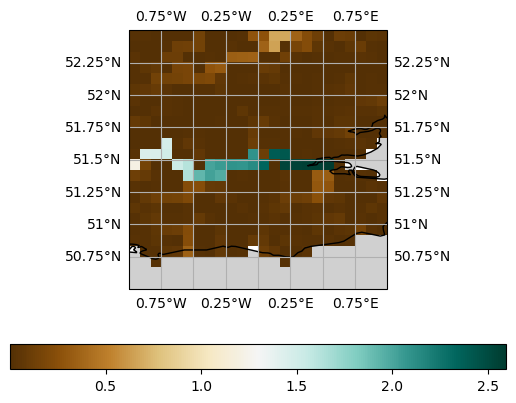

In [26]:
# riv_outはkg/s
josui = load(f'map/dat/cty_prf_/city_{city_index:08d}.gl5', SUF='.gl5')
josui_cropped = crop(josui, lat_start, lat_end, lon_start, lon_end)

qtot = load_times_area(f'lnd/out/Qtot____/W5E5LECD20190000.gl5', SUF='.gl5')
qtot_crop = crop(qtot, lat_start, lat_end, lon_start, lon_end)

rivout = load_yearly(f'riv/out/riv_out_/W5E5LECD20190000.gl5', SUF='.gl5')
rivout_crop = crop(rivout, lat_start, lat_end, lon_start, lon_end)

# extent
projection = ccrs.PlateCarree()
img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfea.OCEAN, color='#d0d0d0')
im = ax.imshow(rivout_crop,
               origin='upper',
               extent=img_extent,
               transform=projection,
               cmap='BrBG'
               #cmap='GnBu',
               #norm = LogNorm(vmin=1e-10, vmax=1e2),
              )
fig.colorbar(im, ax=ax, orientation='horizontal')

riv = rivout_crop*josui_cropped
print(np.sum(riv))

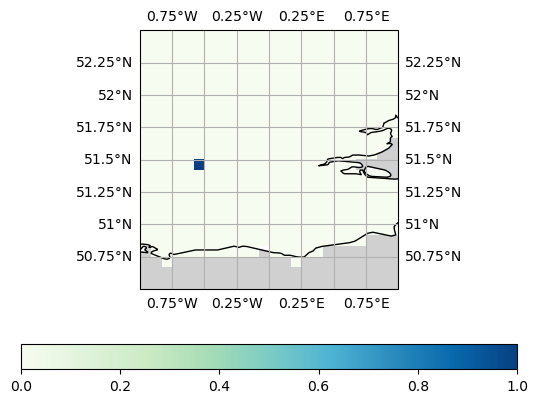

In [27]:
# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfea.OCEAN, color='#d0d0d0')
im = ax.imshow(josui_cropped,
               origin='upper',
               extent=img_extent,
               transform=projection,
               #cmap='BrBG'
               cmap='GnBu',
               #norm = LogNorm(vmin=1e-10, vmax=1e2),
              )
fig.colorbar(im, ax=ax, orientation='horizontal')

In [28]:
# 需要ファイルを参照する

total 9484.391954204708 km3/year
masked_total 0.0 km3/year


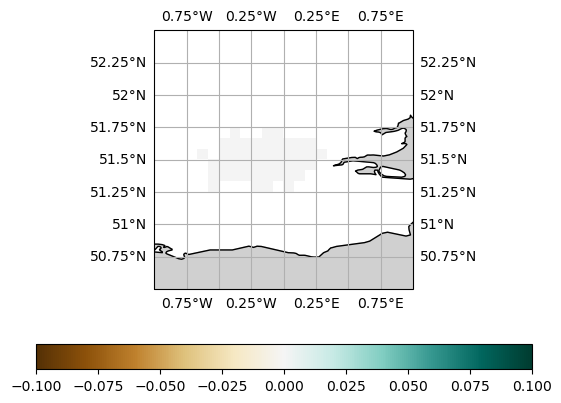

In [29]:
# suplyの単位はkg/s

# load demagr tokyo
demagr = load_yearly('lnd/out/DemAgr__/W5E5LECD20190000.gl5', SUF='.gl5')
demagr_cropped = crop(demagr, lat_start, lat_end, lon_start, lon_end)

# city mask
masked_demagr = np.where(city_cropped == 1, demagr_cropped, np.nan)

# extent
projection = ccrs.PlateCarree()
img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfea.OCEAN, color='#d0d0d0')
im = ax.imshow(masked_demagr,
               origin='upper',
               extent=img_extent,
               transform=projection,
               cmap='BrBG'
               #cmap='GnBu',
               #norm = LogNorm(vmin=1e-10, vmax=1e2),
              )
fig.colorbar(im, ax=ax, orientation='horizontal')

print(f"masked_total {np.nansum(masked_demagr)} km3/year")

total 67.14300090228711 km3/year
masked_total 0.0965463701203125 km3/year


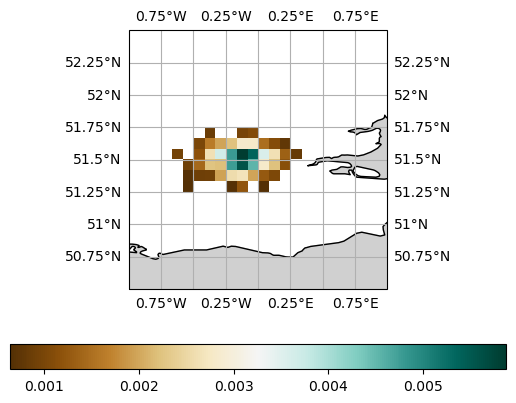

In [30]:
# suplyの単位はkg/s

demind = load_yearly('map/dat/dem_ind_/AQUASTAT20000000.gl5', SUF='.gl5')
demind_cropped = crop(demind, lat_start, lat_end, lon_start, lon_end)

# city mask
masked_demind = np.where(city_cropped == 1, demind_cropped, np.nan)

# extent
projection = ccrs.PlateCarree()
img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfea.OCEAN, color='#d0d0d0')
im = ax.imshow(masked_demind,
               origin='upper',
               extent=img_extent,
               transform=projection,
               cmap='BrBG'
               #cmap='GnBu',
               #norm = LogNorm(vmin=1e-10, vmax=1e2),
              )
fig.colorbar(im, ax=ax, orientation='horizontal')

print(f"masked_total {np.nansum(masked_demind)} km3/year")

total 56.94787264046972 km3/year
masked_total 0.142805381653125 km3/year


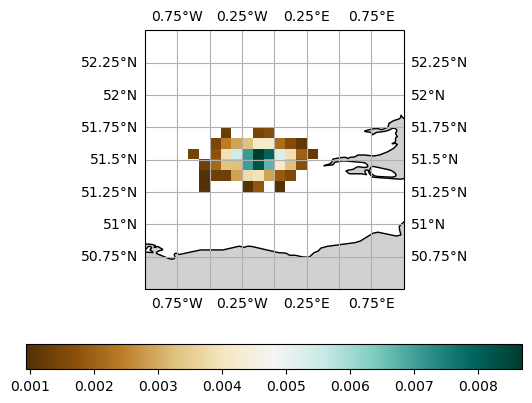

In [31]:
# suplyの単位はkg/s

demdom = load_yearly('map/dat/dem_dom_/AQUASTAT20000000.gl5', SUF='.gl5')
demdom_cropped = crop(demdom, lat_start, lat_end, lon_start, lon_end)

# city mask
masked_demdom = np.where(city_cropped == 1, demdom_cropped, np.nan)

# extent
projection = ccrs.PlateCarree()
img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfea.OCEAN, color='#d0d0d0')
im = ax.imshow(masked_demdom,
               origin='upper',
               extent=img_extent,
               transform=projection,
               cmap='BrBG'
               #cmap='GnBu',
               #norm = LogNorm(vmin=1e-10, vmax=1e2),
              )
fig.colorbar(im, ax=ax, orientation='horizontal')

print(f"masked_total {np.nansum(masked_demdom)} km3/year")

In [32]:
# Water stress
# = (DemAgri + DemInd + DemDom)/(Riv_out)

demagr_tot = np.nansum(masked_demagr)
demind_tot = np.nansum(masked_demind)
demdom_tot = np.nansum(masked_demdom)
riv_total = np.nansum(riv)
wsi = (demagr_tot + demind_tot + demdom_tot)/riv_total

print(demagr_tot, demind_tot, demdom_tot, riv_total)
print(f"wsi {wsi}")

0.0 0.0965463701203125 0.142805381653125 1.611607104
wsi 0.14851743404417106
